## Read data

In [97]:
import csv
import numpy as np

class SonarDataReader:
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = []

    def read_data(self):
        with open(self.filepath, 'r') as file:
            reader = csv.reader(file)
            # headers = next(reader)  # 跳过表头

            for row in reader:
                pose_x = float(row[0])
                pose_y = float(row[1])
                pose_z = float(row[2])
                pose_orient_x = float(row[3])
                pose_orient_y = float(row[4])
                pose_orient_z = float(row[5])
                pose_orient_w = float(row[6])

                w_p = np.array(eval(row[7]))
                s_p = np.array(eval(row[8]))
                si_q = np.array(eval(row[9]))
                si_q_theta_Rho = np.array(eval(row[10]))
                timestep = int(row[11])
                pts_indice = np.array(eval(row[12]))

                self.data.append({
                    'pose': {
                        'position': {'x': pose_x, 'y': pose_y, 'z': pose_z},
                        'orientation': {'x': pose_orient_x, 'y': pose_orient_y, 'z': pose_orient_z, 'w': pose_orient_w}
                    },
                    'w_p': w_p,
                    's_p': s_p,
                    'si_q': si_q,
                    'si_q_theta_Rho': si_q_theta_Rho,
                    'timestep': timestep,
                    'pts_indice': pts_indice
                })

    def get_data(self):
        return self.data

filepath = "sonar_data.csv"
reader = SonarDataReader(filepath)
reader.read_data()
data = reader.get_data()

# 测试打印读取的数据
for entry in data:
    print("Pose Position: ", entry['pose']['position'])
    print("Pose Orientation: ", entry['pose']['orientation'])
    # print("w_p: ", entry['w_p'])
    # print("s_p: ", entry['s_p'])
    # print("si_q: ", entry['si_q'])
    # print("si_q_theta_d: ", entry['si_q_theta_d'])
    # print("Timestep: ", entry['timestep'])
    # print("Pts Indice: ", entry['pts_indice'])
    # print("\n")
    break

Pose Position:  {'x': -1.8282061483920884, 'y': -0.4641462448660301, 'z': -0.4141030741960442}
Pose Orientation:  {'x': -0.0776951287448076, 'y': 0.062462536984540046, 'z': -0.0776951287448076, 'w': 0.9919805267302936}


## integrate tri with ANP 

### Utility function

In [98]:
import numpy as np
import transforms3d

def quaternion_to_rotation_matrix(quaternion):
    """将四元数转换为旋转矩阵"""
    return transforms3d.quaternions.quat2mat(quaternion)

def pose_to_transform_matrix(pose):
    """将位姿转换为齐次变换矩阵"""
    position = pose['position']
    orientation = pose['orientation']
    
    # 提取平移向量
    translation = np.array([position['x'], position['y'], position['z']])
    
    # 提取四元数并转换为旋转矩阵
    quaternion = [orientation['w'], orientation['x'], orientation['y'], orientation['z']]
    rotation_matrix = quaternion_to_rotation_matrix(quaternion)
    
    # 构建齐次变换矩阵
    transform_matrix = np.eye(4)
    transform_matrix[:3, :3] = rotation_matrix
    transform_matrix[:3, 3] = translation
    
    return transform_matrix


In [99]:
def compute_D(T_matrix, theta, theta_prime):
    
    R = T_matrix[:3, :3]
    t = T_matrix[:3, 3]
    
    """
    Compute the determinant D(A0; R, t) for given parameters.
    """
    def skew_symmetric_matrix(t):
        """
        Create a skew-symmetric matrix for a vector t.
        """
        return np.array([
            [0, -t[2], t[1]],
            [t[2], 0, -t[0]],
            [-t[1], t[0], 0]
        ])
    ux = np.array([1, 0, 0])
    uy = np.array([0, 1, 0])
    
    r1 = R[0, :]
    r2 = R[1, :]
        
    t_cross = skew_symmetric_matrix(t)
    
    determinant = - (r1 - np.tan(theta) * r2).T @ t_cross @ (ux - np.tan(theta_prime) * uy)
    
    return determinant

# determinant = compute_D(T_matrix, theta=theta_Rho[0], theta_prime=theta_Rho_prime[0])
# print("determiant: ", determinant)
##########################################################################


In [100]:
def get_match_pairs(si_q_theta_Rho, pts_indice, si_q_theta_Rho_prime, pts_indice_prime):
    
    # 找到共同的索引
    common_indices = np.intersect1d(pts_indice, pts_indice_prime)

    # 获取t0时刻的匹配坐标
    t0_indices = [np.where(pts_indice == idx)[0][0] for idx in common_indices]
    matched_t0 = si_q_theta_Rho[t0_indices]

    # 获取t1时刻的匹配坐标
    t1_indices = [np.where(pts_indice_prime == idx)[0][0] for idx in common_indices]
    matched_t1 = si_q_theta_Rho_prime[t1_indices]
    
    return matched_t0, matched_t1, common_indices

### Main Process

In [101]:
from anp.anp import AnPAlgorithm
anp_algorithm = AnPAlgorithm()
# t_s_cal, R_sw_cal = anp_algorithm.compute_t_R(P_SI_Noise, P_W)
from tri.tri import ANRS, GTRS

T_z_90 = np.array([[0,-1,0,0],[1,0,0,0],[0,0,1,0],[ 0,0,0,1]])
T_z_min90 = T_z_90.T
R_z_90 = T_z_90[:3, :3]

def coordinate_transform_T(T0, T1):
    # T1 = T0 @ T
    T_matrix = np.linalg.inv(T0) @ T1 
    # x-axis oriented switched to y-axis oriented
    T_matrix = T_z_90 @ T_matrix @ T_z_min90
    # get transforamtion matrix
    T_matrix = np.linalg.inv(T_matrix)
    return T_matrix

def coordinate_transform_Pose(Pose):
    return (T_z_90 @ Pose @ T_z_min90)

def coordinate_transform_pt(P):
    return (R_z_90 @ P)

def coordinate_transform(p0, p1, T0, T1):
    p0 = coordinate_transform_pt(p0)
    p1 = coordinate_transform_pt(p1)
    T_matrix = coordinate_transform_T(T0, T1)
    return p0, p1, T_matrix


# TRI

In [102]:
record = []

for timestep in range(len(data)-1):

    T0 = pose_to_transform_matrix(data[timestep]['pose'])
    T1 = pose_to_transform_matrix(data[timestep+1]['pose']) # This is what we need to initialize

    T0 = coordinate_transform_Pose(T0)
    T1 = coordinate_transform_Pose(T1)
    T_matrix = np.linalg.inv(T1) @ T0

    theta_Rho0 = data[timestep]['si_q_theta_Rho']
    pts_indice0 = data[timestep]['pts_indice']
    theta_Rho1 = data[timestep+1]['si_q_theta_Rho']
    pts_indice1 = data[timestep+1]['pts_indice']

    s_p0_gt = data[timestep]['s_p']
    w_p0_gt = data[timestep]['w_p']
    s_p1_gt = data[timestep+1]['s_p']
    w_p1_gt = data[timestep+1]['w_p']
    
    theta_Rho, theta_Rho_prime, common_indices = get_match_pairs(theta_Rho0, pts_indice0, theta_Rho1, pts_indice1)

    # Just for double check
    w_P_gt = data[timestep+1]['w_p']
    w_P_gt_indices = [np.where(pts_indice1 == idx)[0][0] for idx in common_indices]
    w_P_gt = w_P_gt[w_P_gt_indices] 
    w_P_gt = coordinate_transform_pt( w_P_gt.T ).T
    reconstrubtion_error_list = []
    
    determinant_list = []
    for i in range(len(theta_Rho)):
        determinant = compute_D(T_matrix, theta=theta_Rho[i][0], theta_prime=theta_Rho_prime[i][0])
        determinant_list.append(determinant)
        # s_P = GTRS(T_matrix, theta_Rho[i], theta_Rho_prime[i])
        s_P = ANRS(T_matrix, theta_Rho[i], theta_Rho_prime[i])
        w_P = ( T0 @ np.hstack([s_P, 1]) )[:3]
        key = common_indices[i]
   
        difference = np.linalg.norm( w_P - w_P_gt[i] )
        reconstrubtion_error_list.append(difference)

    determinant_evaluation = sum(abs(x) for x in determinant_list) / len(determinant_list)
    reconstrubtion_error_evaluation = sum(abs(x) for x in reconstrubtion_error_list) / len(reconstrubtion_error_list)
    record.append((determinant_evaluation, reconstrubtion_error_evaluation))

In [103]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Extracting x and y coordinates
x_coords, y_coords = zip(*record)



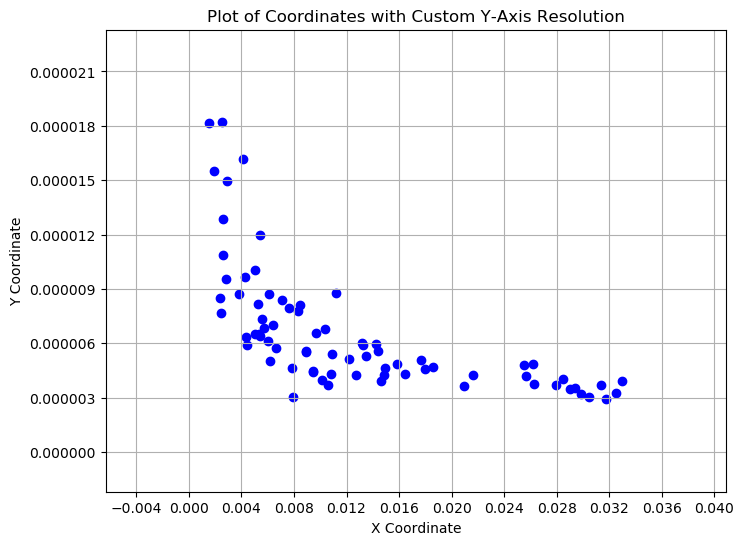

In [104]:
# Plotting the coordinates with autoscale for y axis
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, color='blue')
plt.title('Plot of Coordinates with Custom Y-Axis Resolution')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)

# Setting y-axis to autoscale and custom resolution
plt.autoscale(enable=True, axis='y', tight=True)
ax = plt.gca()

# Manually setting y-axis limits to increase the scale
x_min, x_max = min(x_coords), max(x_coords)
x_range = x_max - x_min
ax.set_xlim(x_min - x_range/4, x_max + x_range/4)  # Expand y-axis range by a factor
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set the maximum number of ticks to 10

# Manually setting y-axis limits to increase the scale
y_min, y_max = min(y_coords), max(y_coords)
y_range = y_max - y_min
ax.set_ylim(y_min - y_range/3, y_max + y_range/3)  # Expand y-axis range by a factor
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))  # Set the maximum number of ticks to 10

plt.show()


In [80]:
x_coords

(0.00832562413581686,
 0.016432758703815623,
 0.025507191678371056,
 0.029845003667795904,
 0.0325068555517823,
 0.02941012268721573,
 0.026160035309226556,
 0.01855065386392446,
 0.014396661928816222,
 0.009422375455194896,
 0.006652724674868688,
 0.005743366207653976,
 0.005022303815515162,
 0.004308453853377378,
 0.0043060116152998295,
 0.006103320137783163,
 0.007916869548942312,
 0.009418991849406306,
 0.010550043747072434,
 0.012196027293955835,
 0.014890870503677376,
 0.014849817370851436,
 0.013498661227036466,
 0.010367090903542613,
 0.007590337236205537,
 0.005526310332998972,
 0.0038129126187445533,
 0.0023672220816444685,
 0.0025792958811954063,
 0.0025048920290658768,
 0.0015356421353805688,
 0.005292143475839222,
 0.01321484051792266,
 0.021651534283801982,
 0.02846018224314101,
 0.03134742891865136,
 0.03176937488139885,
 0.027914485710865133,
 0.02092981625354826,
 0.015870653527120304,
 0.010897967062110412,
 0.0078361011813518,
 0.006040595468467004,
 0.00531094561690

In [3]:
import numpy as np

# 定义投影函数，将三维点投影到二维平面上
def project_to_2d(P):
    X, Y, Z = P
    theta = np.arctan2(X, Y)
    d = np.sqrt(X**2 + Y**2 + Z**2)
    x_s = d * np.sin(theta)
    y_s = d * np.cos(theta)
    return np.array([x_s, y_s])

# 定义误差函数
def error_function(P, ps, ps_prime, Q, Q_prime, T_matrix):
    R = T_matrix[:3, :3]
    t = T_matrix[:3, 3]
    # 投影点
    ps_hat = project_to_2d(P)
    P_prime = R @ P + t
    ps_prime_hat = project_to_2d(P_prime)
    
    # 计算误差
    error_ps = ps - ps_hat
    error_ps_prime = ps_prime - ps_prime_hat
    
    # 计算加权误差
    error = error_ps.T @ Q @ error_ps + error_ps_prime.T @ Q_prime @ error_ps_prime
    return error

# 定义梯度下降法进行优化
def gradient_descent(P_init, ps, ps_prime, Q, Q_prime, T_matrix, learning_rate=0.01, max_iter=1000, tol=1e-6):
    
    P = P_init
    for i in range(max_iter):
        # 计算当前误差
        error = error_function(P, ps, ps_prime, Q, Q_prime, T_matrix)
        
        # 计算梯度
        grad = np.zeros_like(P)
        for j in range(len(P)):
            P_temp = P.copy()
            P_temp[j] += tol
            grad[j] = (error_function(P_temp, ps, ps_prime, Q, Q_prime, T_matrix) - error) / tol
        
        # 更新P
        P_new = P - learning_rate * grad
        
        # 检查收敛
        if np.linalg.norm(P_new - P) < tol:
            break
        
        P = P_new
        print(f"Iteration {i+1}, Error: {error}")
    
    return P

# 示例数据
P_init = np.array([1.0, 1.0, 1.0])  # 初始三维点
ps = np.array([0.5, 0.5])  # 测量的二维点
ps_prime = np.array([0.4, 0.6])  # 测量的二维点（第二视角）
Q = np.eye(2)  # 加权矩阵
Q_prime = np.eye(2)  # 加权矩阵（第二视角）
T_matrix = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[ 0,0,0,1]])

# 优化三维点
P_optimized = gradient_descent(P_init, ps, ps_prime, Q, Q_prime, T_matrix)
print("Optimized P:", P_optimized)


Iteration 1, Error: 2.1210205144336447
Iteration 2, Error: 1.9551293982446163
Iteration 3, Error: 1.8022634444152106
Iteration 4, Error: 1.6614009514367472
Iteration 5, Error: 1.5316003034790753
Iteration 6, Error: 1.4119936935114183
Iteration 7, Error: 1.3017813389383903
Iteration 8, Error: 1.2002261506540752
Iteration 9, Error: 1.1066488199310691
Iteration 10, Error: 1.020423290782868
Iteration 11, Error: 0.9409725867639309
Iteration 12, Error: 0.8677649654541966
Iteration 13, Error: 0.8003103741115237
Iteration 14, Error: 0.738157183083696
Iteration 15, Error: 0.6808891753573507
Iteration 16, Error: 0.628122772009457
Iteration 17, Error: 0.5795044750181748
Iteration 18, Error: 0.5347085104863792
Iteration 19, Error: 0.49343465651355445
Iteration 20, Error: 0.4554062411777993
Iteration 21, Error: 0.42036829747318877
Iteration 22, Error: 0.38808586256312183
Iteration 23, Error: 0.3583424104543976
Iteration 24, Error: 0.33093840723075985
Iteration 25, Error: 0.30568997955708277
Iterati